# Chapter 01

## Introduction

In [1]:
# noinspection PyUnresolvedReferences
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
# noinspection PyUnresolvedReferences
import scipy.stats as stats
# noinspection PyUnresolvedReferences
import seaborn as sns

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import fractions

### A farmer or a librarian?

In [3]:
# 300 dots per inch for saved figures and inline plots
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

In [4]:
prior = np.array([fractions.Fraction(1, 21), fractions.Fraction(20, 21)])
likelihood = np.array([fractions.Fraction(95, 100), fractions.Fraction(5, 10)])
products = prior * likelihood
posterior = products / sum(products)

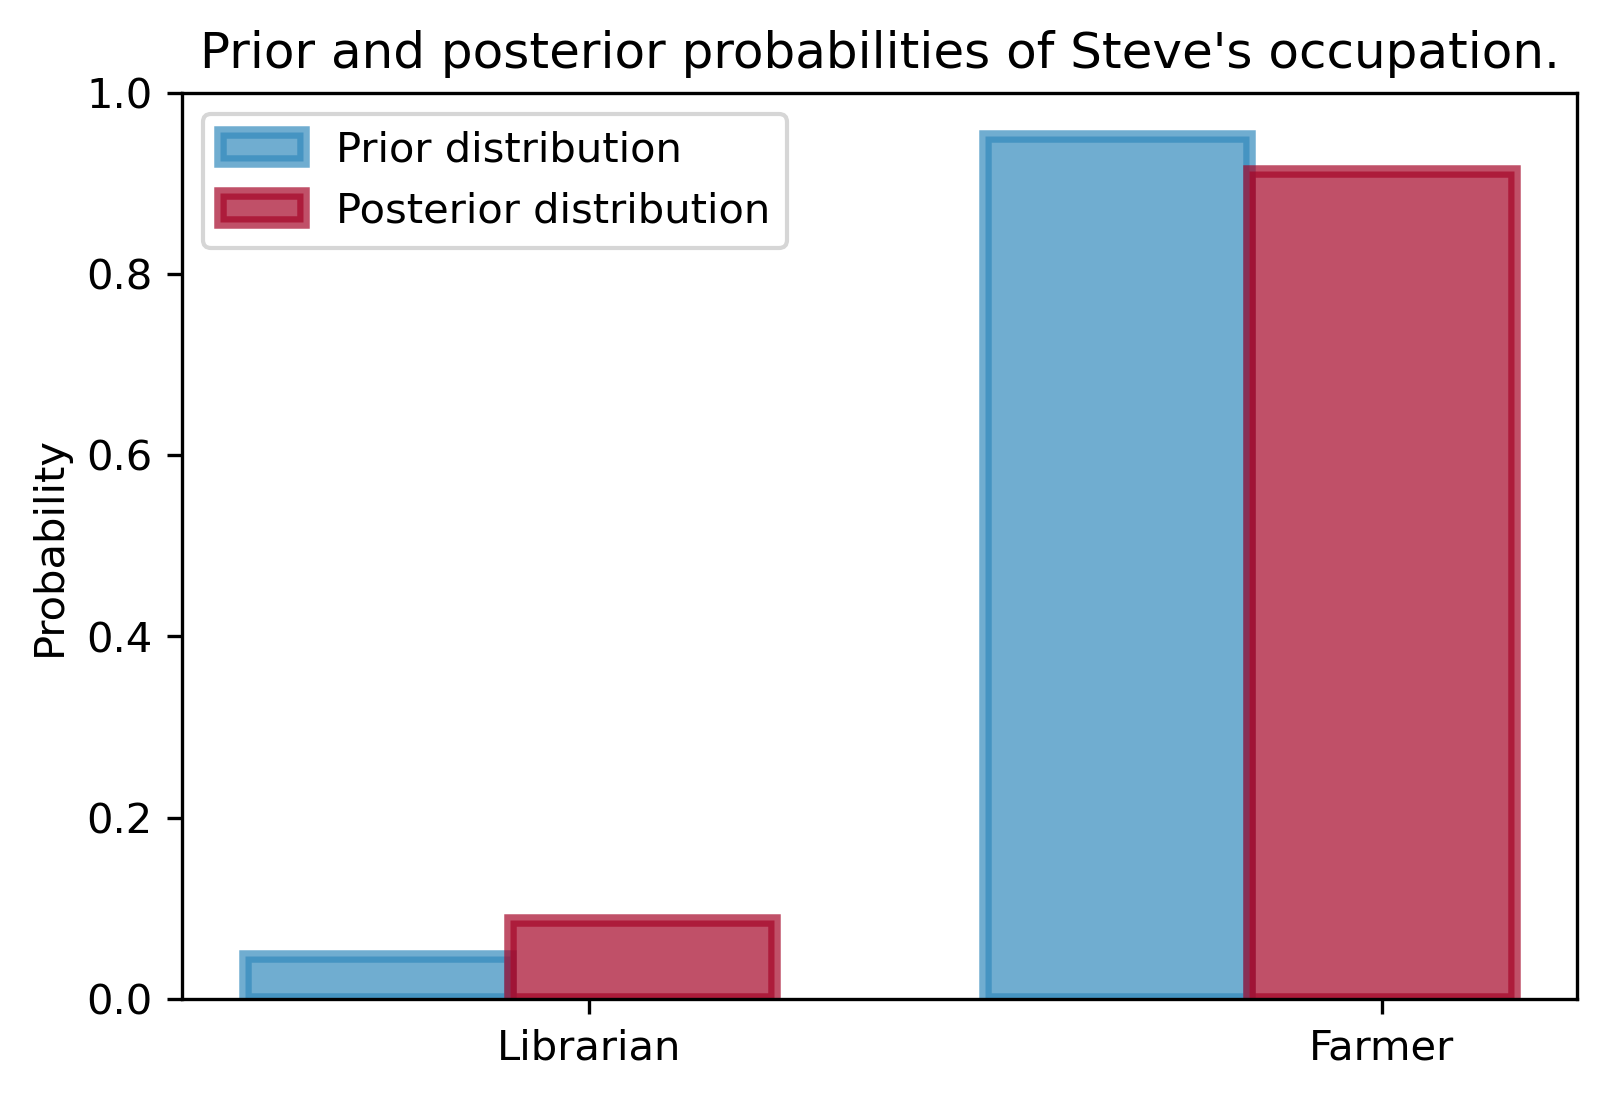

In [5]:
colors = ['#348abd', '#a60628']
plt.bar([0, 0.7], prior, alpha=0.7, width=0.25, color = colors[0],
        label='Prior distribution', lw='3', edgecolor=colors[0])
plt.bar([0 + 0.25, 0.7 + 0.25], posterior, alpha=0.7, width=0.25,
        color=colors[1], label='Posterior distribution',
        lw='3', edgecolor=colors[1])
plt.xticks([0.20, 0.95], ['Librarian', 'Farmer'])
plt.title("Prior and posterior probabilities of Steve's occupation.")
plt.ylabel('Probability')
plt.legend(loc='upper left')

### Distributions

A probability distribution is a function of a random variable, often
called _Z_, that maps _Z_ to a value such that the sum over all values of
_Z_ (either continuous or discrete) is one. That is, a probability
distribution is a function whose sum over all range values for each member
of the domain is exactly one.

#### Poisson distribution

A Poisson distribution is a discrete distribution (each member of the domain
is "distinct" or "seperated" from other members of the domain). The domain
of the Poisson distribution is the set of non-negative integers (infinite,
but countably infinite). The shape is controlled by a single (shape?)
parameter, _lambda_. Higher values of _lambda_ result in a higher probability
mass for larger elements of the domain.

The mean, first moment, or expectation of a Poisson distribution with
parameter, _lambda_, is $\lambda$.

In [6]:
# Plot on a 12.5" x 4" canvas
plt.figure(figsize=(12.5, 4))
# Using two colors
colors = ['#348abd', '#a60628']

<Figure size 3750x1200 with 0 Axes>

In [7]:
# Plot two different Poisson distributions (probability mass functions)
a = np.arange(16)  # 16 x-values
poi = stats.poisson  # save a couple of keystrokes
# Note the trailing underscore because `lambda` is a keyword
lambda_ = [1.5, 4.25]

Text(0.5, 1.0, 'Probability mass function of a Poisson random variable but differing $\\lambda$ values.')

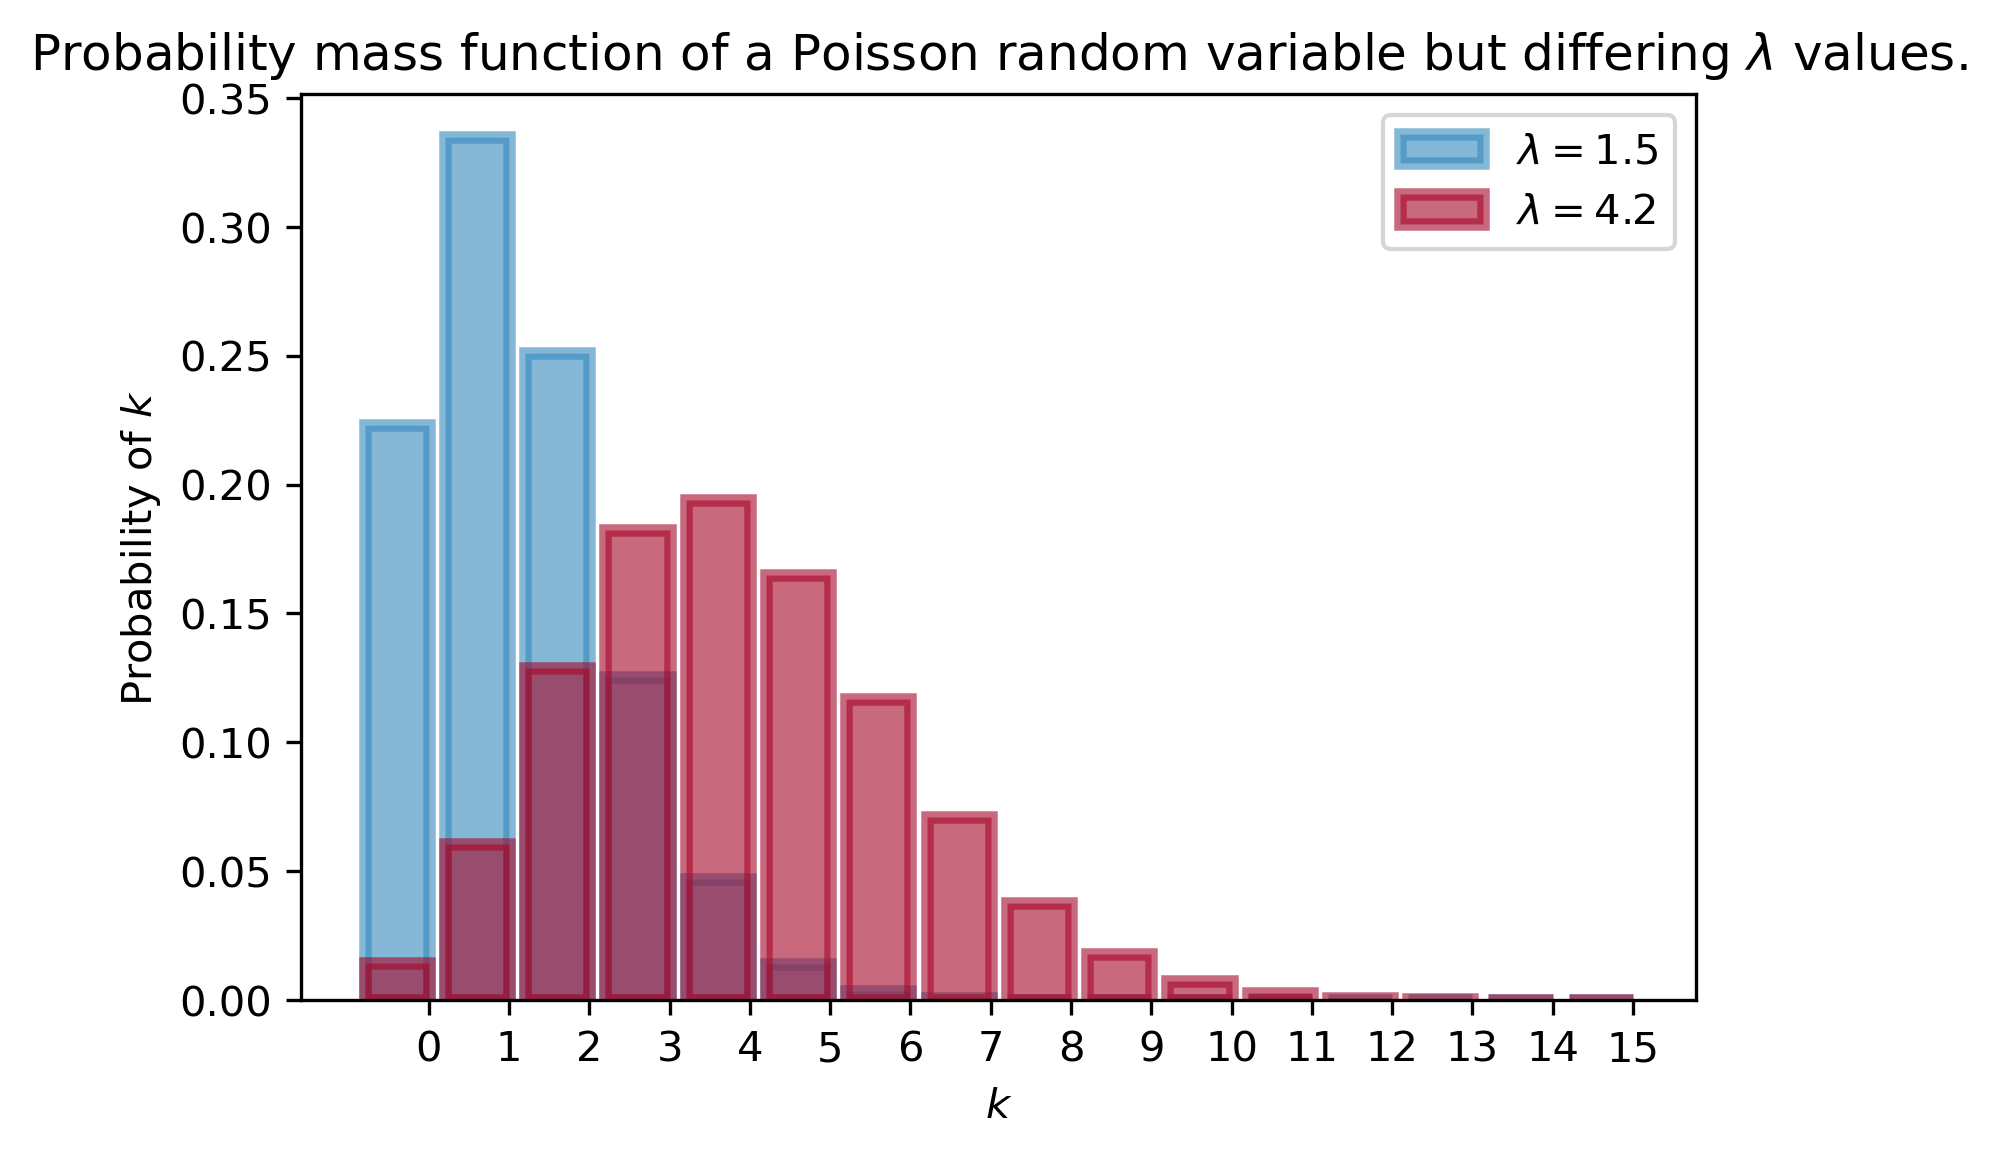

In [8]:
# Calculate the probability "mass" of the Poisson distribution at each _a_
plt.bar(a, poi.pmf(a, lambda_[0]), color=colors[0],
        label=f'$\lambda = {lambda_[0]:.1f}$', alpha=0.60, edgecolor=colors[0], lw='3')
plt.bar(a, poi.pmf(a, lambda_[1]), color=colors[1],
        label=f'$\lambda = {lambda_[1]:.1f}$', alpha=0.60, edgecolor=colors[1], lw='3')
plt.xticks(a + 0.4, a)
plt.legend()
plt.ylabel('Probability of $k$')
plt.xlabel('$k$')
plt.title('Probability mass function of a Poisson random variable but'
          ' differing $\lambda$ values.')

#### Exponential distribution

An exponential distribution is a continuous distribution (members of the domain
are continuous). The domain of the exponential distribution is the set of
real numbers. The shape is controlled by a single (shape?) parameter, _lambda_.
Higher values of _lambda_ result in a higher probability mass for larger members
of the domain.

The mean, first moment, or expectation of an exponential distribution with
parameter, _lambda_, is $1 / \lambda$.

In [9]:
a = np.linspace(0, 4, 100)  # Sample real numbers linearly
expo = stats.expon
lambda_ = [0.5, 1]

Text(0.5, 1.0, 'Probability density function of an exponential random variable, differing $\\lambda$ values')

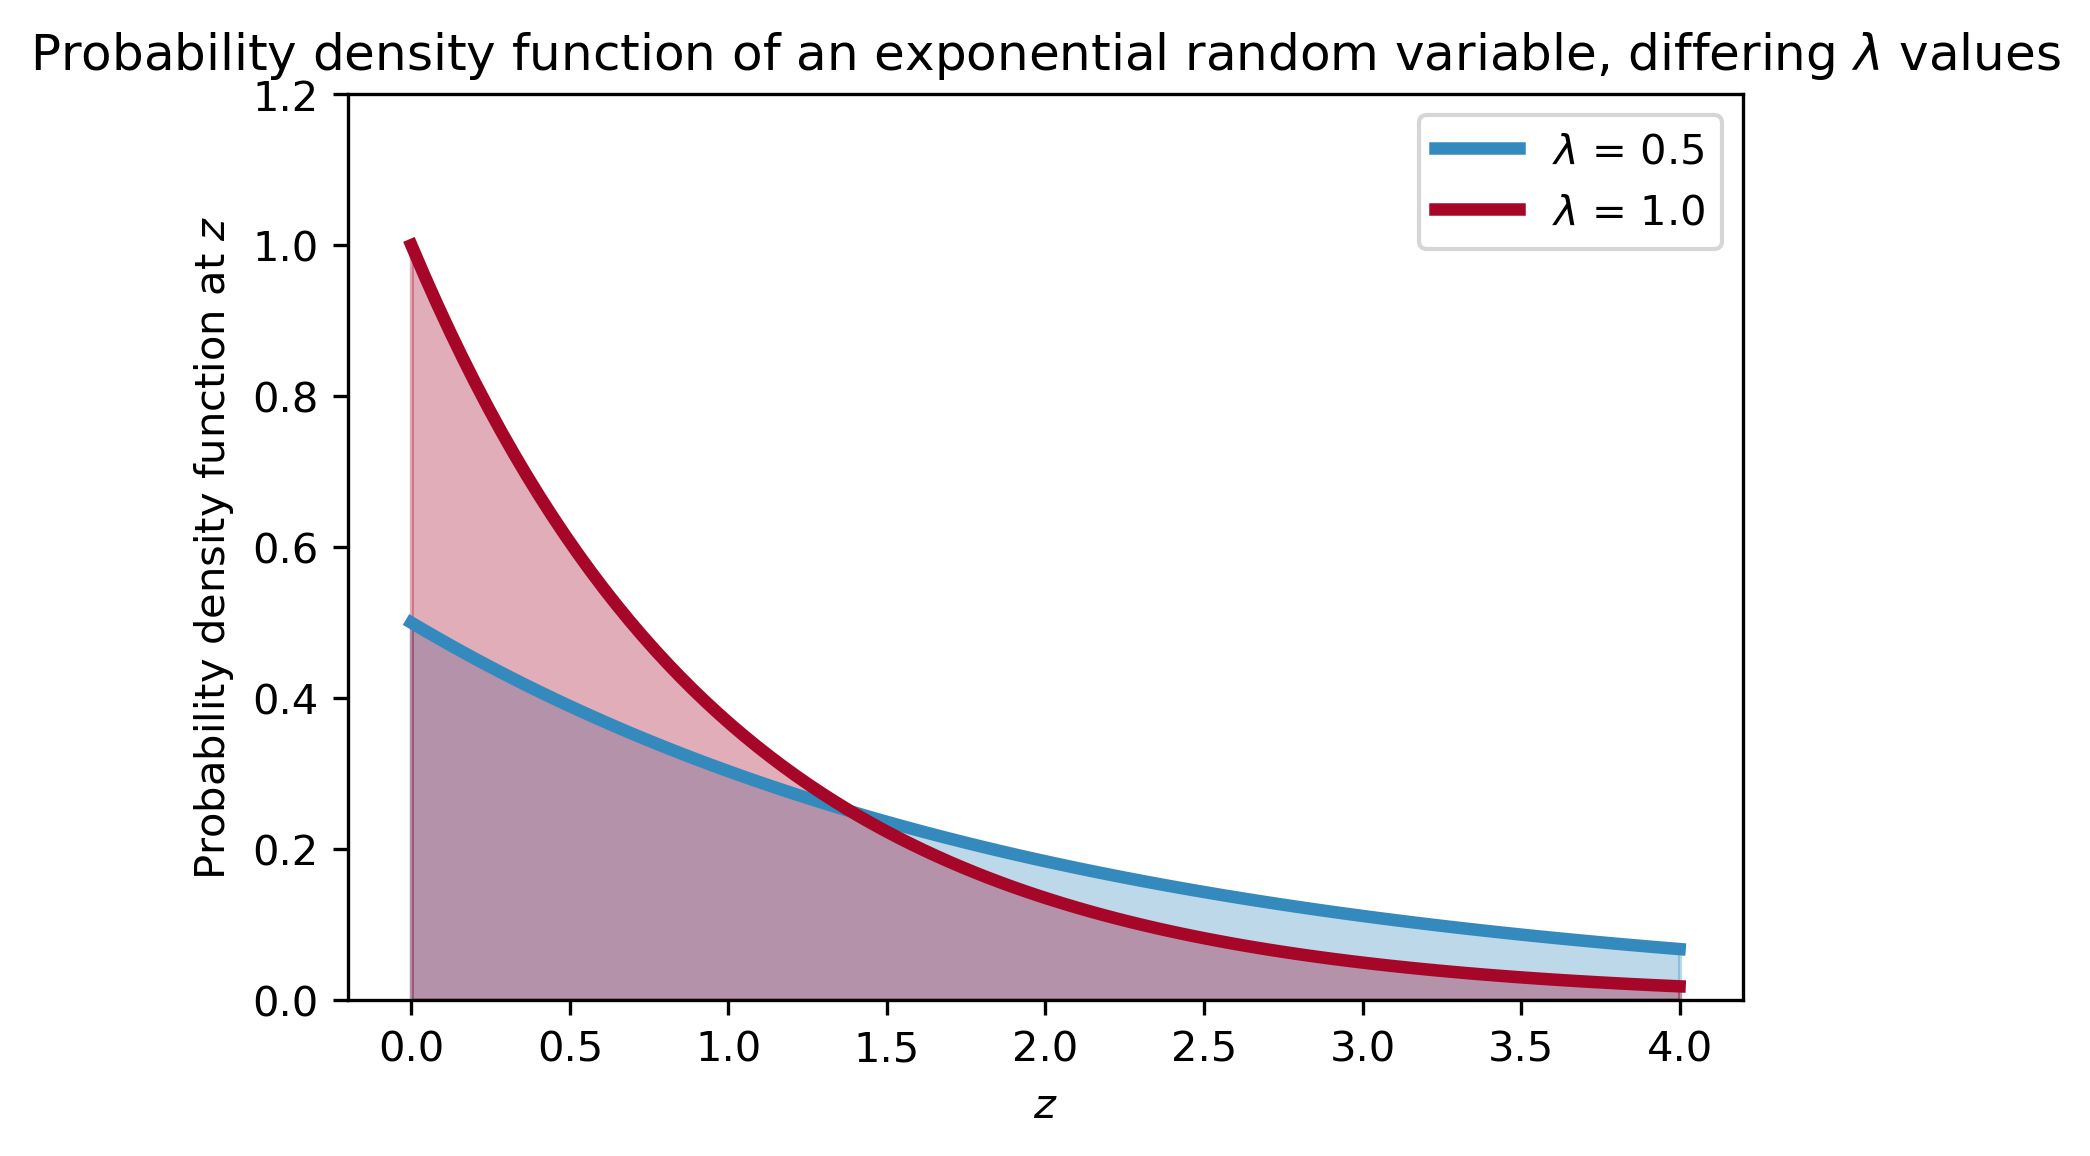

In [10]:
for l, c in zip(lambda_, colors):
    plt.plot(a, expo.pdf(a, scale=1 / l), lw=3, color=c,
                         label=f'$\lambda$ = {l:.1f}')
    plt.fill_between(a, expo.pdf(a, scale=1 / l), color=c, alpha=0.33)
plt.legend()
plt.ylabel('Probability density function at $z$')
plt.xlabel('$z$')
plt.ylim(0, 1.2)
plt.title('Probability density function of an exponential random variable,'
          ' differing $\lambda$ values')

### Bayesian inference using computers

You are given a series of daily text message counts from a user of your
system. You are curious if the user's text messaging habits have changed
over time, either gradually or suddenly. How can you model this?

#### Plot the text message counts over time.

In [11]:
# Plot on a 12.5" x 3.5" "canvas"
plt.figure(figsize=(12.5, 3.5))

<Figure size 3750x1050 with 0 Axes>

<Figure size 3750x1050 with 0 Axes>

In [12]:
# Read in the data (single column text file, I believe)
count_data = np.loadtxt('data/txtdata.csv')
n_count_data = len(count_data)

(0.0, 74.0)

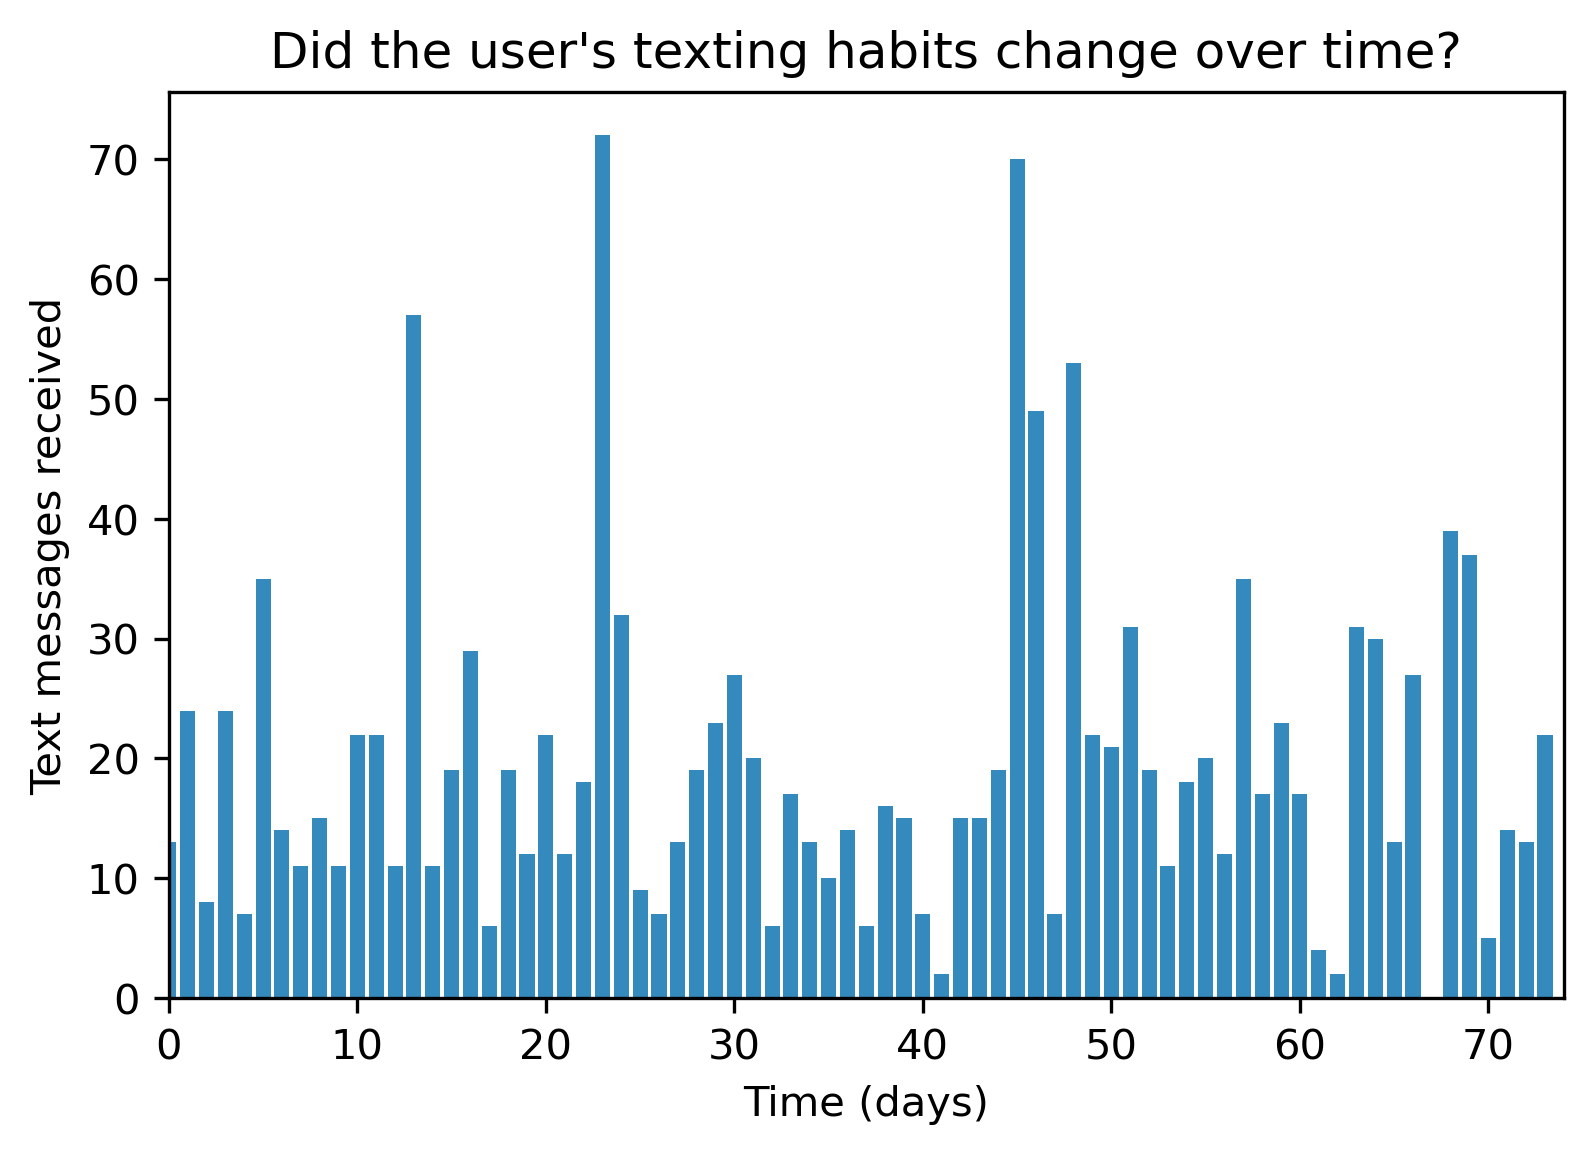

In [13]:
# Plot a bar chart: text message counts over time
plt.bar(np.arange(n_count_data), count_data, color='#348abd')
plt.xlabel('Time (days)')
plt.ylabel('Text messages received')
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data)

#### Modeling the counts over time

The author suggests modeling the counts using a Poisson distribution; that is,
$$
C_{i} \sim \mathrm{Poisson}(\lambda)
$$

However, $\lambda$, is a parameter whose value is **unknown**; consequently, we use Bayesian inference to infer a distribution of values for this parameter.

The author further posits that $\lambda$ actually changes (discontinuously) over time. That is, $\lambda$ is drawn from a _switchover_ at time, $\tau$.

$$
\lambda = \left\{
    \begin{array}\\
        \lambda_{1} \mbox{ if } \mathrm{t} < \tau \\
        \lambda_{2} \mbox{ if } \mathrm{t} \geq \tau
    \end{array}
\right.
$$

In order to infer the values $\lambda_{1}$ and $\lambda_{2}$, we must assign prior probabilities to these values. Because the $\lambda$ parameter for the Poisson distribution accepts any **positive** number, we need a distribution that generates positive numbers. The exponential distribution provides a continuous distribution for positive values so the author suggests using this distribution as follows:

$$
\begin{array}\\
    \lambda_{1} \sim \mathrm{Exp}(\alpha) \\
    \lambda_{2} \sim \mathrm{Exp}(\alpha)
\end{array}
$$

where \alpha is a _hyperparameter_; that is, a parameter that influences other **parameters**.

The author argues that setting $\alpha$ to the inverse of the sample average of the count data like

$$
\frac{1}{\mathrm{N}} \sum_{i = 0}^{\mathrm{N}} \mathrm{C}_{i} \approx \mathbb{E} [ \lambda\mid\alpha ] = \frac{1}{\alpha}
$$

The author does not detail his reasoning for this choice; however, the following explanation seems reasonable to me.

The counts are distributed as a Poisson distribution with parameter $\lambda$. The expectation of a Poisson distribution with parameter $\lambda$ is also $\lambda$. The sample mean of the counts is given by the summation expression in the previous section, and we want the sample mean to be the inverse of $\alpha$ but $\frac{1}{\alpha}$ is also the expectation of the parameter, $\lambda \mid \alpha$, for the exponential distribution.

The author states that this choice of hyperparameter is "not very opinionated in our prior"; that is, the prior minimizes the influence of the hyperparameter.

Finally, the author posits using a uniform distribution for $\tau$, the time at which the $\lambda$ parameter of the Poisson distribution changes. That is,

$$
\tau \sim \mathrm{DiscreteUniform}(0, 70)
$$

He argues that this choice is reasonable because of the noisiness of the data.

This distribution implies that

$$
\mathcal{P}(\tau = \mathcal{k}) = \frac{1}{70}
$$

## Introducing our first hammer: PyMC3

In [15]:
# Create the stochastic variables for our model
with pm.Model():
    alpha = 1.0 / (count_data.mean())  # `count_data` holds our counts
    lambda_1 = pm.Exponential('lambda_1', alpha)
    lambda_2 = pm.Exponential('lambda_2', alpha)
    tau = pm.DiscreteUniform('tau', 0, n_count_data)